In [148]:
import os
import re
import sys
from collections import defaultdict
from IPython.display import HTML, display

def print_in_red(text):
    display(HTML(f'<span style="color:red">{text}</span>'))
    
def extract_num_input_files(log_content):
    match = re.search(r'Found (\d+) input read files to process', log_content)
    if match:
        return int(match.group(1))
    return 0

def extract_samples_per_second(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    pattern = re.compile(r'Caller time: \d+ ms, Samples called: \d+, samples/s: (\d+\.?\d*)e?(\+?-?\d*)')
    match = pattern.search(content)
    
    num_input_files = extract_num_input_files(content)
    
    if num_input_files>20:
        if match:
            samples_per_second = float(match.group(1) + 'e' + match.group(2))
            return samples_per_second
        else:
            print(f"Pattern not found in the file: {file_path}")
            return None
    else:
        print_in_red(f"Too few file processed: {num_input_files}")
        print(f"In the file: {file_path}")

        return None


def process_files(directory_path, file_patterns):
    samples_per_second_dict = defaultdict(list)

    # Iterate over files in the specified directory based on the file patterns
    for file_pattern in file_patterns:
        for filename in os.listdir(directory_path):
            if re.match(file_pattern, filename):
                file_path = os.path.join(directory_path, filename)
                result = extract_samples_per_second(file_path)

                if result is not None:
                    samples_per_second_dict[file_pattern].append((filename, result))

    return samples_per_second_dict

def calculate_average(samples_per_second_dict):
    averages = {}

    for file_pattern, results in samples_per_second_dict.items():
        if results:
            average_value = sum(value for _, value in results) / len(results)
            averages[file_pattern] = average_value
        else:
            averages[file_pattern] = None

    return averages

def calculate_var(average, samples_per_second_dict):
    var = {}
    for file_pattern, results in samples_per_second_dict.items():
        if results:
            var_value = sum((value-average[file_pattern])**2 for _, value in results) / len(results)
            var[file_pattern] = var_value
        else:
            var[file_pattern] = None

    return var

In [149]:
def sum_averages(dir_path):
    directory_path = dir_path
    file_patterns = [r'dgx001_\d+_hac\.txt',r'dgx002_\d+_hac\.txt', r'gpu001_\d+_hac\.txt', r'gpu002_\d+_hac\.txt', r'gpu003_\d+_hac\.txt', r'gpu004_\d+_hac\.txt',
                    r'dgx001_\d+_sup\.txt',r'dgx002_\d+_sup\.txt', r'gpu001_\d+_sup\.txt', r'gpu002_\d+_sup\.txt', r'gpu003_\d+_sup\.txt', r'gpu004_\d+_sup\.txt']
    results = process_files(directory_path, file_patterns)
    
    if results:
        print("Samples per second for each file pattern:")
        for file_pattern, file_results in results.items():
            print(f"\nFile pattern: {file_pattern}")
            for i, (filename, result) in enumerate(file_results, start=1):
                print(f"  File {i}: {filename}, Samples per second: {result}")
    
            average_values = calculate_average(results)
            if average_values[file_pattern] is not None:
                print(f"  Average samples per second: {average_values[file_pattern]}")
            else:
                print("  Unable to calculate the average.")
    
        print(average_values)
        # Print the sum of averages for both file patterns
        sum_of_averages = sum(average_value for average_value in average_values.values() if average_value is not None)
        print(f"\nSum of averages for both patterns: {sum_of_averages}")
        return sum_of_averages


In [150]:
def compute_variance(dir_path):
    directory_path = dir_path
    file_patterns = [r'dgx001_\d+_hac\.txt',r'dgx002_\d+_hac\.txt', r'gpu001_\d+_hac\.txt', r'gpu002_\d+_hac\.txt', r'gpu003_\d+_hac\.txt', r'gpu004_\d+_hac\.txt',
                    r'dgx001_\d+_sup\.txt',r'dgx002_\d+_sup\.txt', r'gpu001_\d+_sup\.txt', r'gpu002_\d+_sup\.txt', r'gpu003_\d+_sup\.txt', r'gpu004_\d+_sup\.txt']
    results = process_files(directory_path, file_patterns)
    
    if results:
        #print("Samples per second for each file pattern:")
        for file_pattern, file_results in results.items():
            print(f"\nFile pattern: {file_pattern}")
            for i, (filename, result) in enumerate(file_results, start=1):
                print(f"  File {i}: {filename}, Samples per second: {result}")
    
            average_values = calculate_average(results)
            var = calculate_var(average_values, results)
            if average_values[file_pattern] is not None:
                print(f"  Variance for samples per second: {var[file_pattern]}")
            else:
                print("  Unable to calculate the Variance.")


In [155]:
import pandas as pd
# Create an empty list to store data
data = []

# Iterate over the runs
for i in range(1, 11):
    directory_path = f"/u/dssc/tolloi/Cluster_Basecalling_Manager/BC_software/orfeo_executable/file_performance_test/bc_logs/run_{i}_splits"
    
    # Call sum_averages function
    print()
    print("AVERAGE")
    result = sum_averages(directory_path)
    #print()
    #print("VARIANCE")
    #var = compute_variance(directory_path)
    
    # Append the result to the list
    data.append({'Run': i, 'Batch size' : 584.0/i, 'Sum of Averages': result/(10*1000*1000*1000)})

# Convert the list to a DataFrame
df = pd.DataFrame(data);



AVERAGE
Samples per second for each file pattern:

File pattern: dgx002_\d+_sup\.txt
  File 1: dgx002_1_sup.txt, Samples per second: 492338000.0
  Average samples per second: 492338000.0
{'dgx002_\\d+_sup\\.txt': 492338000.0}

Sum of averages for both patterns: 492338000.0

AVERAGE
Samples per second for each file pattern:

File pattern: dgx002_\d+_sup\.txt
  File 1: dgx002_1_sup.txt, Samples per second: 481509000.0
  File 2: dgx002_2_sup.txt, Samples per second: 501534000.0
  Average samples per second: 491521500.0
{'dgx002_\\d+_sup\\.txt': 491521500.0}

Sum of averages for both patterns: 491521500.0

AVERAGE


In the file: /u/dssc/tolloi/Cluster_Basecalling_Manager/BC_software/orfeo_executable/file_performance_test/bc_logs/run_3_splits/dgx002_4_sup.txt
Samples per second for each file pattern:

File pattern: dgx002_\d+_sup\.txt
  File 1: dgx002_1_sup.txt, Samples per second: 468895000.0
  File 2: dgx002_2_sup.txt, Samples per second: 500091000.0
  File 3: dgx002_3_sup.txt, Samples per second: 500669000.0
  Average samples per second: 489885000.0
{'dgx002_\\d+_sup\\.txt': 489885000.0}

Sum of averages for both patterns: 489885000.0

AVERAGE
Samples per second for each file pattern:

File pattern: dgx002_\d+_sup\.txt
  File 1: dgx002_4_sup.txt, Samples per second: 502019000.0
  File 2: dgx002_1_sup.txt, Samples per second: 467997000.0
  File 3: dgx002_2_sup.txt, Samples per second: 501743000.0
  File 4: dgx002_3_sup.txt, Samples per second: 501914000.0
  Average samples per second: 493418250.0
{'dgx002_\\d+_sup\\.txt': 493418250.0}

Sum of averages for both patterns: 493418250.0

AVERAGE


In the file: /u/dssc/tolloi/Cluster_Basecalling_Manager/BC_software/orfeo_executable/file_performance_test/bc_logs/run_5_splits/dgx002_6_sup.txt
Samples per second for each file pattern:

File pattern: dgx002_\d+_sup\.txt
  File 1: dgx002_5_sup.txt, Samples per second: 500442000.0
  File 2: dgx002_4_sup.txt, Samples per second: 500287000.0
  File 3: dgx002_1_sup.txt, Samples per second: 458014000.0
  File 4: dgx002_2_sup.txt, Samples per second: 500516000.0
  File 5: dgx002_3_sup.txt, Samples per second: 500297000.0
  Average samples per second: 491911200.0
{'dgx002_\\d+_sup\\.txt': 491911200.0}

Sum of averages for both patterns: 491911200.0

AVERAGE


In the file: /u/dssc/tolloi/Cluster_Basecalling_Manager/BC_software/orfeo_executable/file_performance_test/bc_logs/run_6_splits/dgx002_7_sup.txt
Samples per second for each file pattern:

File pattern: dgx002_\d+_sup\.txt
  File 1: dgx002_5_sup.txt, Samples per second: 498535000.0
  File 2: dgx002_4_sup.txt, Samples per second: 499045000.0
  File 3: dgx002_6_sup.txt, Samples per second: 499169000.0
  File 4: dgx002_1_sup.txt, Samples per second: 447931000.0
  File 5: dgx002_2_sup.txt, Samples per second: 499440000.0
  File 6: dgx002_3_sup.txt, Samples per second: 499039000.0
  Average samples per second: 490526500.0
{'dgx002_\\d+_sup\\.txt': 490526500.0}

Sum of averages for both patterns: 490526500.0

AVERAGE


In the file: /u/dssc/tolloi/Cluster_Basecalling_Manager/BC_software/orfeo_executable/file_performance_test/bc_logs/run_7_splits/dgx002_8_sup.txt
Samples per second for each file pattern:

File pattern: dgx002_\d+_sup\.txt
  File 1: dgx002_5_sup.txt, Samples per second: 498904000.0
  File 2: dgx002_4_sup.txt, Samples per second: 498717000.0
  File 3: dgx002_6_sup.txt, Samples per second: 498705000.0
  File 4: dgx002_1_sup.txt, Samples per second: 438294000.0
  File 5: dgx002_2_sup.txt, Samples per second: 498433000.0
  File 6: dgx002_7_sup.txt, Samples per second: 499283000.0
  File 7: dgx002_3_sup.txt, Samples per second: 498457000.0
  Average samples per second: 490113285.71428573
{'dgx002_\\d+_sup\\.txt': 490113285.71428573}

Sum of averages for both patterns: 490113285.71428573

AVERAGE
Samples per second for each file pattern:

File pattern: dgx002_\d+_sup\.txt
  File 1: dgx002_5_sup.txt, Samples per second: 495828000.0
  File 2: dgx002_8_sup.txt, Samples per second: 494970000.0
  

In the file: /u/dssc/tolloi/Cluster_Basecalling_Manager/BC_software/orfeo_executable/file_performance_test/bc_logs/run_9_splits/dgx002_10_sup.txt
Samples per second for each file pattern:

File pattern: dgx002_\d+_sup\.txt
  File 1: dgx002_5_sup.txt, Samples per second: 497252000.0
  File 2: dgx002_8_sup.txt, Samples per second: 497495000.0
  File 3: dgx002_4_sup.txt, Samples per second: 495394000.0
  File 4: dgx002_6_sup.txt, Samples per second: 497644000.0
  File 5: dgx002_1_sup.txt, Samples per second: 425083000.0
  File 6: dgx002_2_sup.txt, Samples per second: 497486000.0
  File 7: dgx002_9_sup.txt, Samples per second: 497788000.0
  File 8: dgx002_7_sup.txt, Samples per second: 497582000.0
  File 9: dgx002_3_sup.txt, Samples per second: 496866000.0
  Average samples per second: 489176666.6666667
{'dgx002_\\d+_sup\\.txt': 489176666.6666667}

Sum of averages for both patterns: 489176666.6666667

AVERAGE


In the file: /u/dssc/tolloi/Cluster_Basecalling_Manager/BC_software/orfeo_executable/file_performance_test/bc_logs/run_10_splits/dgx002_11_sup.txt
Samples per second for each file pattern:

File pattern: dgx002_\d+_sup\.txt
  File 1: dgx002_5_sup.txt, Samples per second: 497452000.0
  File 2: dgx002_8_sup.txt, Samples per second: 496729000.0
  File 3: dgx002_4_sup.txt, Samples per second: 497661000.0
  File 4: dgx002_6_sup.txt, Samples per second: 497953000.0
  File 5: dgx002_10_sup.txt, Samples per second: 498478000.0
  File 6: dgx002_1_sup.txt, Samples per second: 417135000.0
  File 7: dgx002_2_sup.txt, Samples per second: 497298000.0
  File 8: dgx002_9_sup.txt, Samples per second: 497583000.0
  File 9: dgx002_7_sup.txt, Samples per second: 497728000.0
  File 10: dgx002_3_sup.txt, Samples per second: 497981000.0
  Average samples per second: 489599800.0
{'dgx002_\\d+_sup\\.txt': 489599800.0}

Sum of averages for both patterns: 489599800.0


In [153]:
# Print the DataFrame
print(df)

   Run  Batch size  Sum of Averages
0    1  584.000000     4.923380e+08
1    2  292.000000     4.915215e+08
2    3  194.666667     4.898850e+08
3    4  146.000000     4.934182e+08
4    5  116.800000     4.919112e+08
5    6   97.333333     4.905265e+08
6    7   83.428571     4.901133e+08
7    8   73.000000     4.878742e+08
8    9   64.888889     4.891767e+08
9   10   58.400000     4.895998e+08


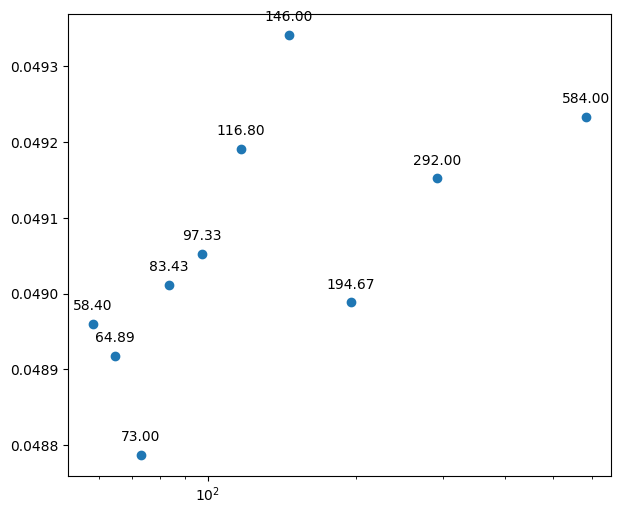

In [156]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 6))

plt.scatter(df['Batch size'],df['Sum of Averages'])
plt.xscale('log')


for i, size in enumerate(df['Batch size']):
    ax.annotate(f'{size:.2f}', (size, df['Sum of Averages'].iloc[i]),
                textcoords="offset points", xytext=(0, 10), ha='center')
